In [61]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors
from sklearn.model_selection import train_test_split
from scipy.linalg import svd

def load_data(filename, usecols = (), skiprows = 0, delimiter=','):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string.
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    return np.loadtxt(filename, skiprows=skiprows, delimiter=delimiter, usecols= usecols)

In [62]:
movies = load_data('data/movies.txt', usecols = range(2, 20), delimiter='\t')
movies = np.concatenate((np.array([x for x in range(1, movies.shape[0] + 1)])[:, np.newaxis], movies), axis=1)
user_data = load_data('data/data.csv', skiprows = 1)

# For getting the movie names, do this instead.
import csv
with open("data/movies.txt", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    movieNames = np.array(list(reader))
    
movieNames = movieNames[:,1]

In [63]:
print(movieNames[0])

Toy Story (1995)


In [64]:
##### MATRIX FACTORIZATION METHODS FROM HW 5 HERE #####

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # Gradient as calculated in 2a
    gradient = (reg * Ui) - ((Yij - np.dot(Ui, Vj)) * Vj)

    return eta * gradient

def grad_U_with_bias(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # Gradient as calculated in 2a
    gradient = (reg * Ui) - (((Yij - mu) - (np.dot(Ui, Vj) + ai + bj)) * Vj)

    return eta * gradient

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient as calculated in 2a
    gradient = (reg * Vj) - ((Yij - np.dot(Ui, Vj)) * Ui)

    return eta * gradient

def grad_V_with_bias(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient as calculated in 2a
    gradient = (reg * Vj) - (((Yij - mu) - (np.dot(Ui, Vj) + ai + bj)) * Ui)

    return eta * gradient

def grad_a(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Computes the gradient with respect to ai, a trained constant
    """
    gradient = (reg * ai) - ((Yij - mu) - (np.dot(Ui, Vj) + ai + bj))
    
    return eta * gradient
    

def grad_b(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Computes the gradient with respect to bj, a trained constant
    """
    gradient = (reg * bj) - ((Yij - mu) - (np.dot(Ui, Vj) + ai + bj))
    
    return eta * gradient

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Don't include the regularization in the error term, only need for grad update
    error = 0
    for ind in range(Y.shape[0]):
        i = Y[ind][0] - 1
        j = Y[ind][1] - 1
        Yij = Y[ind][2]
        Ui = U[i] # ith row
        Vj = V[j] # jth row
        error += ((Yij - np.dot(Ui, Vj)) ** 2) / 2

    return error / Y.shape[0] # Divide error by size of dataset to get mean err.

def get_err_with_bias(U, V, Y, a, b, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Don't include the regularization in the error term, only need for grad update
    error = 0
    for ind in range(Y.shape[0]):
        
        i = Y[ind][0] - 1
        j = Y[ind][1] - 1
        Yij = Y[ind][2]
        Ui = U[i] # ith row
        Vj = V[j] # jth row
        ai = a[i] # ith bias
        bj = b[j] # jth bias
        error += (((Yij - mu) - (np.dot(Ui, Vj) + ai + bj)) ** 2) / 2

    return error / Y.shape[0] # Divide error by size of dataset to get mean err.

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300, useBias=False):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U and V
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    if (useBias):
        a = np.random.rand(M) - 0.5
        b = np.random.rand(N) - 0.5
        mu = np.mean(Y[:,2])
        
    # Initialize errors
    relativeLoss = 1e5
    zerothLoss = -1
    firstLoss = -1
    lastLoss = -1
    ep = 0
    while (ep < max_epochs and relativeLoss > eps):
        
        # Shuffle the data
        np.random.shuffle(Y)
        
        # Update the U and V matrices with appropriate grad updates
        for ind in range(Y.shape[0]):
            i = Y[ind][0] - 1 # -1 to ensure 0 indexing
            j = Y[ind][1] - 1
            Yij = Y[ind][2]
            Ui = U[i] # ith row
            Vj = V[j] # jth row
            if (useBias):
                ai = a[i]
                bj = b[j]
            # Perform gradient updates
            if (useBias):
                U[i] -= grad_U_with_bias(Ui, Yij, Vj, ai, bj, mu, reg, eta)
                V[j] -= grad_V_with_bias(Vj, Yij, Ui, ai, bj, mu, reg, eta)
                a[i] -= grad_a(Vj, Yij, Ui, ai, bj, mu, reg, eta)
                b[j] -= grad_b(Vj, Yij, Ui, ai, bj, mu, reg, eta)
            else:
                U[i] -= grad_U(Ui, Yij, Vj, reg, eta)
                V[j] -= grad_V(Vj, Yij, Ui, reg, eta)
            


        # Calculate the current Error
        err = get_err_with_bias(U, V, Y, a, b, mu, reg) if useBias else get_err(U, V, Y, reg)

        # Update learnDif
        if (ep == 0):
            zerothLoss = err
        elif (ep == 1):
            firstLoss = err
        else:
            relativeLoss = (lastLoss - err) / (zerothLoss - firstLoss)

        # Set lastLoss for next epoch
        lastLoss = err


        # Next epoch
        ep += 1
        print("Epoch: ", ep, " Error: ", err)
    
    return (U, V, a, b, mu, err) if useBias else (U, V, err) 

In [65]:
# Get the data to do matrix factorization on
#Y_train, Y_test, _, __ = train_test_split(user_data.astype(int), user_data, test_size=0.1)
with open("data/train.txt", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    Y_train = np.array(list(reader)).astype(int)
    
with open("data/test.txt", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    Y_test = np.array(list(reader)).astype(int)
    
print(Y_train.shape, Y_test.shape)

(90000, 3) (10000, 3)


In [66]:
######### SECTION 1: NO BIAS TERM USED ###########

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
# K = 20 given by assignment
K= 20

reg = 0.1  # From finnnicking around, this is a good amount of regularization.
eta = 0.03 # learning rate, same from hw5

# Train model, same as HW5
U,V, err = train_model(M, N, K, eta, reg, Y_train)
test_err = get_err(U, V, Y_test)
print('Test Error: ', test_err)

# Have to transpose the matrices to be the correct shape.
U = np.transpose(U)
V = np.transpose(V)

Factorizing with  943  users,  1682  movies.
Epoch:  1  Error:  0.50533645514
Epoch:  2  Error:  0.42939113154
Epoch:  3  Error:  0.4051257352
Epoch:  4  Error:  0.384573931739
Epoch:  5  Error:  0.370868501479
Epoch:  6  Error:  0.358881126248
Epoch:  7  Error:  0.349214728284
Epoch:  8  Error:  0.34218976617
Epoch:  9  Error:  0.334791268488
Epoch:  10  Error:  0.325258799926
Epoch:  11  Error:  0.323085647039
Epoch:  12  Error:  0.319654756911
Epoch:  13  Error:  0.313459264631
Epoch:  14  Error:  0.310482690576
Epoch:  15  Error:  0.305267854294
Epoch:  16  Error:  0.303750519113
Epoch:  17  Error:  0.298737001148
Epoch:  18  Error:  0.298630710609
Epoch:  19  Error:  0.296014971646
Epoch:  20  Error:  0.293232732007
Epoch:  21  Error:  0.294525072399
Test Error:  0.447871526799


In [67]:
# Now that we have a model trained, we can go ahead and do visualizations.
# Step 1 is to perform SVD on our trained V vector
A, _, __ = svd(V, full_matrices=True)

print(U.shape, V.shape, A.shape)

# Next, we take the first two columns of A
A_two = A[:,(0,1)]

print(A_two.shape)

# Now from this, we find U_proj, V_proj using the given formulas
U_proj = np.matmul(np.transpose(A_two), U)
V_proj = np.matmul(np.transpose(A_two), V)

(20, 943) (20, 1682) (20, 20)
(20, 2)


<Figure size 432x288 with 0 Axes>

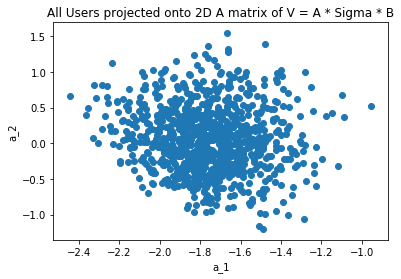

<Figure size 432x288 with 0 Axes>

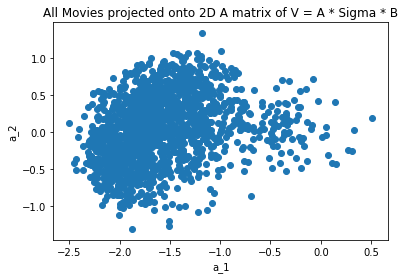

In [68]:
ux = U_proj[0]
uy = U_proj[1]

vx = V_proj[0]
vy = V_proj[1]

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(ux, uy)
plt.title('All Users projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vx, vy)
plt.title('All Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

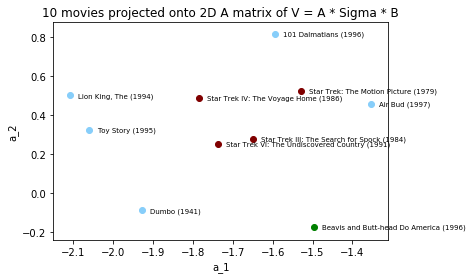

In [69]:
# Indices of 10 movies of my choosing 
# Movies: Star Trek 1,3,4,6, Dumbo, Lion King, 101 Dalmations, Air bud, Toy Story, B&BH
picked_indices = [ 226, 229, 228, 448, 500, 70, 224, 260, 0, 239]

vx1 = [vx[index] for index in picked_indices]
vy1 = [vy[index] for index in picked_indices]

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
toUse = []
for i in [21, 21, 21, 21, 110, 110, 110, 110, 110, 81]:
    toUse.append(sorted_names[i])

plt.clf()
for i in range(len(vx1)):
    x, y = vx1[i], vy1[i]
    plt.scatter(x, y, color=toUse[i])
    plt.text(x+.02, y-.01, movieNames[picked_indices[i]], fontsize=7)

plt.title('10 movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

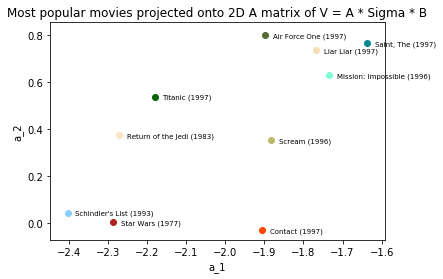

In [70]:
# Indices of 10 most popular movies (most ratings)
popularIndices = [ 49, 257, 180, 293, 287, 299, 312, 404, 747, 317]

vx2 = [vx[index] for index in popularIndices]
vy2 = [vy[index] for index in popularIndices]

toUsePop = []
for i in range(20, 121, 10):
    toUsePop.append(sorted_names[i])

plt.clf()
for i in range(len(vx2)):
    x, y = vx2[i], vy2[i]
    plt.scatter(x, y, color=toUsePop[i])
    plt.text(x+.02, y-.01, movieNames[popularIndices[i]], fontsize=7)
plt.title('Most popular movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

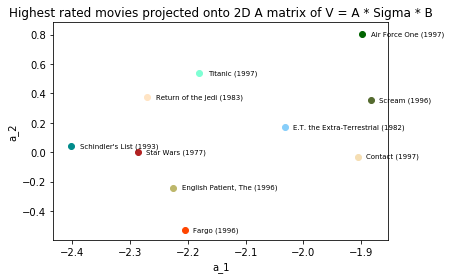

In [80]:
# Indices of 10 highest rated movies on average
highestRatedIndices = [ 49,  99, 180, 257, 285, 287, 299, 312, 317, 422]
#  49, 99, 126, 3, 180, 5, 6, 7, 8, 9 -OLD INDICES, these are incorrect.

vx3 = [vx[index] for index in highestRatedIndices]
vy3 = [vy[index] for index in highestRatedIndices]

toUseRat = []
for i in range(20, 121, 10):
    toUseRat.append(sorted_names[i])

plt.clf()
for i in range(len(vx3)):
    x, y = vx3[i], vy3[i]
    plt.scatter(x, y, color=toUseRat[i])
    plt.text(x+.015, y-.01, movieNames[highestRatedIndices[i]], fontsize=7)
plt.title('Highest rated movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

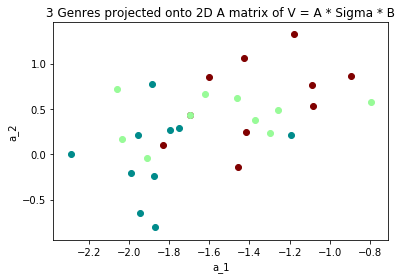

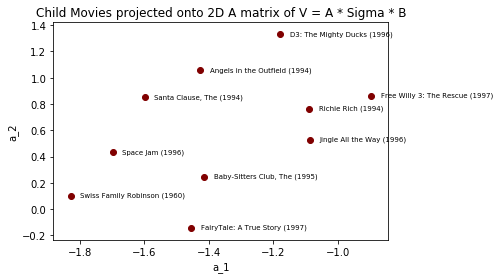

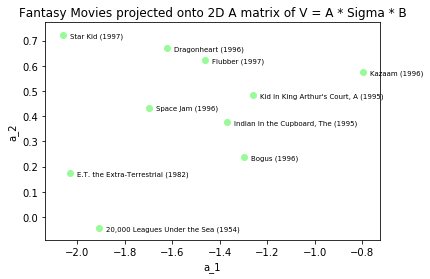

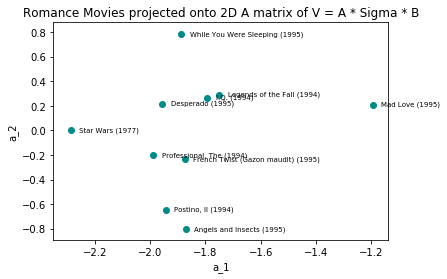

In [72]:
# Indices of 30 movies from 3 genres from Part 4
genreIndices = [137, 794,  62, 456, 621, 790, 307, 861, 622, 819, # child
                831, 422, 950, 891, 819, 559, 140, 471, 1335, 1292, # fantasy
                13, 15, 19, 32, 35, 48, 49, 50, 54, 65] # romance

vx4 = [vx[index] for index in genreIndices]
vy4 = [vy[index] for index in genreIndices]

toUseGen = []
spam = [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 
        76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
for i in spam:
    toUseGen.append(sorted_names[i])

plt.clf()
for i in range(len(vx4)):
    x, y = vx4[i], vy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    # plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('3 Genres projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(0,10):
    x, y = vx4[i], vy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Child Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(10,20):
    x, y = vx4[i], vy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Fantasy Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(20,30):
    x, y = vx4[i], vy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Romance Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()


In [15]:
########### SECTION 2: MATRIX FACTORIZATION WITH BIAS ##############

# NOTE: We already have Y_train, Y_test, and K, so we do not redeclare

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

reg = 0.1  # From finnnicking around, this is a good amount of regularization.
eta = 0.03 # learning rate, same from hw5

# Train model, same as HW5, but add in bias
Ub, Vb, a, b, mu, err = train_model(M, N, K, eta, reg, Y_train, useBias=True)
test_err = get_err_with_bias(Ub, Vb, Y_test, a, b, mu, reg)
print('Test Error: ', test_err)

# Have to transpose the matrices to be the correct shape.
Ub = np.transpose(Ub)
Vb = np.transpose(Vb)

Epoch:  1  Error:  0.423327890398
Epoch:  2  Error:  0.399896396878
Epoch:  3  Error:  0.386245549337
Epoch:  4  Error:  0.372680534542
Epoch:  5  Error:  0.358708168096
Epoch:  6  Error:  0.346266422443
Epoch:  7  Error:  0.334693417302
Epoch:  8  Error:  0.325478633299
Epoch:  9  Error:  0.316166202289
Epoch:  10  Error:  0.308149270215
Epoch:  11  Error:  0.301463159027
Epoch:  12  Error:  0.294980401549
Epoch:  13  Error:  0.290542521208
Epoch:  14  Error:  0.285729965205
Epoch:  15  Error:  0.280687404483
Epoch:  16  Error:  0.278912408126
Epoch:  17  Error:  0.275138209431
Epoch:  18  Error:  0.272339264714
Epoch:  19  Error:  0.269526285163
Epoch:  20  Error:  0.267730062319
Epoch:  21  Error:  0.264728723829
Epoch:  22  Error:  0.263472206911
Epoch:  23  Error:  0.261655935121
Epoch:  24  Error:  0.259870353797
Epoch:  25  Error:  0.258822153035
Epoch:  26  Error:  0.258110095656
Epoch:  27  Error:  0.256676643473
Epoch:  28  Error:  0.255841681544
Epoch:  29  Error:  0.2554070

In [16]:
# Now that we have a model trained, we can go ahead and do visualizations.
# Step 1 is to perform SVD on our trained V vector
Ab, _, __ = svd(Vb, full_matrices=True)

print(U.shape, Vb.shape, A.shape)

# Next, we take the first two columns of A
Ab_two = Ab[:,(0,1)]

print(Ab_two.shape)

# Now from this, we find U_proj, V_proj using the given formulas
Ub_proj = np.matmul(np.transpose(Ab_two), Ub)
Vb_proj = np.matmul(np.transpose(Ab_two), Vb)

(20, 943) (20, 1682) (20, 20)
(20, 2)


<Figure size 432x288 with 0 Axes>

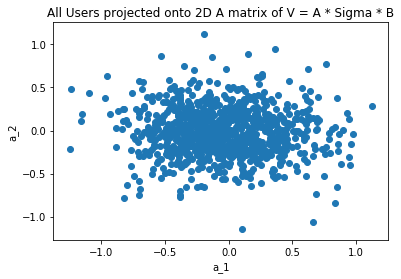

<Figure size 432x288 with 0 Axes>

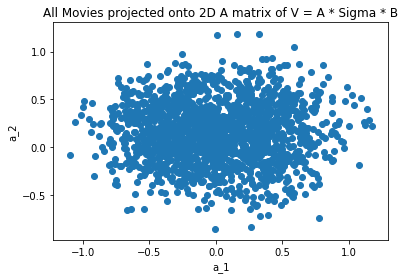

In [17]:
ubx = Ub_proj[0]
uby = Ub_proj[1]

vbx = Vb_proj[0]
vby = Vb_proj[1]

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(ubx, uby)
plt.title('All Users projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vbx, vby)
plt.title('All Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

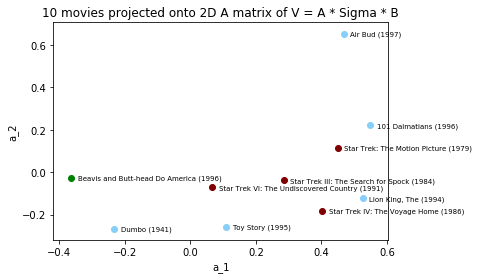

In [18]:
vbx1 = [vbx[index] for index in picked_indices]
vby1 = [vby[index] for index in picked_indices]

plt.clf()
for i in range(len(vbx1)):
    x, y = vbx1[i], vby1[i]
    plt.scatter(x, y, color=toUse[i])
    plt.text(x+.02, y-.01, movieNames[picked_indices[i]], fontsize=7)
plt.title('10 movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

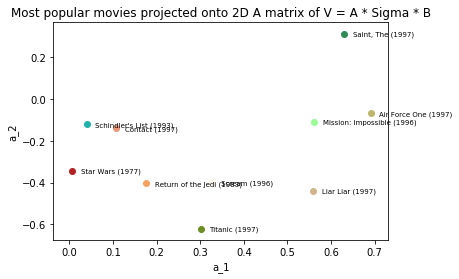

In [19]:
vbx2 = [vbx[index] for index in popularIndices]
vby2 = [vby[index] for index in popularIndices]

toUsePop = []
for i in range(20, 101, 8):
    toUsePop.append(sorted_names[i])

plt.clf()
for i in range(len(vbx2)):
    x, y = vbx2[i], vby2[i]
    plt.scatter(x, y, color=toUsePop[i])
    plt.text(x+.02, y-.01, movieNames[popularIndices[i]], fontsize=7)
plt.title('Most popular movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

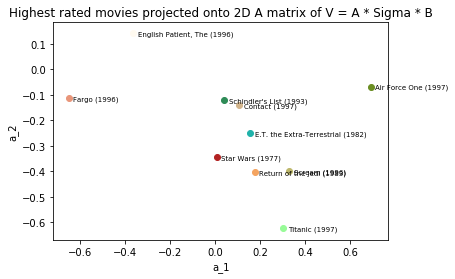

In [81]:
vbx3 = [vbx[index] for index in highestRatedIndices]
vby3 = [vby[index] for index in highestRatedIndices]

toUseRat = []
for i in range(20, 101, 8):
    toUseRat.append(sorted_names[i])

plt.clf()
for i in range(len(vbx3)):
    x, y = vbx3[i], vby3[i]
    plt.scatter(x, y, color=toUseRat[i])
    plt.text(x+.02, y-.01, movieNames[highestRatedIndices[i]], fontsize=7)
plt.title('Highest rated movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

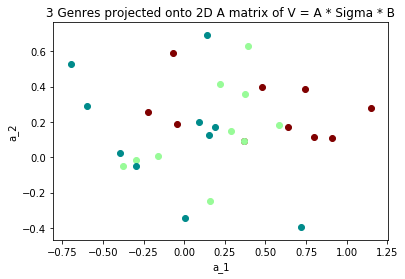

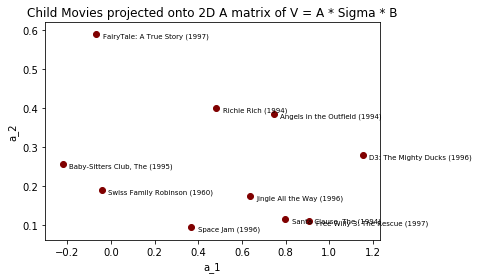

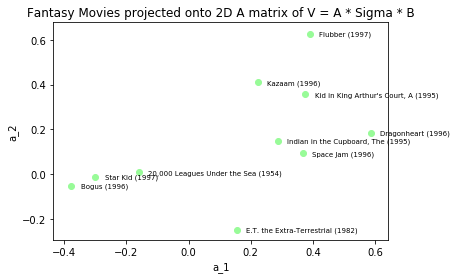

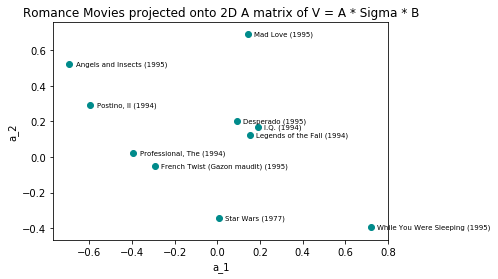

In [21]:
vbx4 = [vbx[index] for index in genreIndices]
vby4 = [vby[index] for index in genreIndices]

toUseGen = []
spam = [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 
        76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
for i in spam:
    toUseGen.append(sorted_names[i])

plt.clf()
for i in range(len(vbx4)):
    x, y = vbx4[i], vby4[i]
    plt.scatter(x, y, color=toUseGen[i])
    # plt.text(x+.02, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('3 Genres projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(0,10):
    x, y = vbx4[i], vby4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Child Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(10,20):
    x, y = vbx4[i], vby4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Fantasy Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(20,30):
    x, y = vbx4[i], vby4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Romance Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

In [33]:
remove = [1349,1363,1458,1541,1561,1576,1579,1581,1606,1633,1651,1666,1667,1678]
movieNamesSurprise = movieNames.copy()
Y_test_surprise = Y_test.copy()
for i in range(len(remove)):
    ind = len(remove) - i - 1
    movieNamesSurprise = np.delete(movieNamesSurprise, remove[ind])
    
for i in range(Y_test_surprise.shape[0]):
    ind = Y_test_surprise.shape[0] - 1 - i
    movie_Ind = Y_test_surprise[ind][1]
    if movie_Ind in remove:
        Y_test_surprise = np.delete(Y_test_surprise, (ind), axis=0)
        
print(Y_test.shape, Y_test_surprise.shape)
print(len(movieNamesSurprise))

(10000, 3) (9985, 3)
1668


In [52]:
########### SECTION 3: OFF-THE-SHELF RECOMMENDER ##############

# NOTE: We already have Y_train, Y_test, so we do not redeclare
from surprise import SVD
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
import pandas as pd


M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

reg = 0.1  # From finnnicking around, this is a good amount of regularization.
eta = 0.03 # learning rate, same from hw5

ratings_dict_train = {'itemID': Y_train[:,1],
                    'userID': Y_train[:,0],
                    'rating': Y_train[:,2]}

ratings_dict_test = {'itemID': Y_test[:,1],
                    'userID': Y_test[:,0],
                    'rating': Y_test[:,2]}

df_train = pd.DataFrame(ratings_dict_train)
df_test = pd.DataFrame(ratings_dict_test)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
datatrain = Dataset.load_from_df(df_train[['userID', 'itemID', 'rating']], reader)
datatest = Dataset.load_from_df(df_test[['userID', 'itemID', 'rating']], reader)

trainset = datatrain.build_full_trainset()

kf = KFold(n_splits=2)
for _, testset in kf.split(datatest):
    pass

# We'll use the famous SVD algorithm.
algo = SVD(n_factors=K, n_epochs=100, lr_all=0.03, reg_all=0.1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
model = algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9154


0.91536491072232018

In [76]:
U_surprise = model.pu
V_surprise = model.qi
a_surprise = model.bu
b_surprise = model.bi

for i in range(Y_test.shape[0]):
    if Y_test[i][1] > 1667:
        print(Y_test[i], i)
        Y_test

err_surprise = get_err_with_bias(U_surprise, V_surprise, Y_test_surprise, a_surprise, b_surprise, mu, reg) / 2
print(err_surprise)

U_surprise = np.transpose(U_surprise)
V_surprise = np.transpose(V_surprise)

[ 863 1678    1] 3975
0.437826665295


In [77]:
# Now that we have a model trained, we can go ahead and do visualizations.
# Step 1 is to perform SVD on our trained V vector
A_surprise, _, __ = svd(V_surprise, full_matrices=True)

print(U_surprise.shape, V_surprise.shape, A_surprise.shape)

# Next, we take the first two columns of A
A_surprise_two = A_surprise[:,(0,1)]

print(A_surprise_two.shape)

# Now from this, we find U_proj, V_proj using the given formulas
U_surprise_proj = np.matmul(np.transpose(A_surprise_two), U_surprise)
V_surprise_proj = np.matmul(np.transpose(A_surprise_two), V_surprise)

(20, 943) (20, 1668) (20, 20)
(20, 2)


<Figure size 432x288 with 0 Axes>

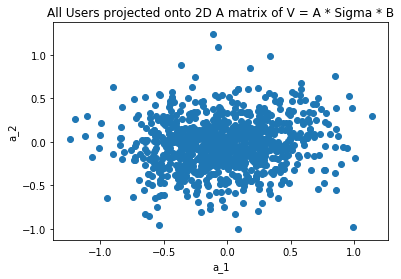

<Figure size 432x288 with 0 Axes>

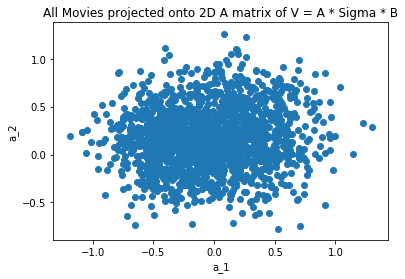

In [78]:
usx = U_surprise_proj[0]
usy = U_surprise_proj[1]

vsx = V_surprise_proj[0]
vsy = V_surprise_proj[1]

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(usx, usy)
plt.title('All Users projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vsx, vsy)
plt.title('All Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

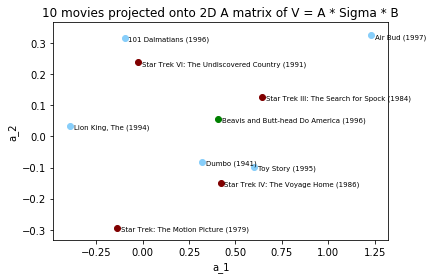

In [79]:
vsx1 = [vsx[index] for index in picked_indices]
vsy1 = [vsy[index] for index in picked_indices]

plt.clf()
for i in range(len(vsx1)):
    x, y = vsx1[i], vsy1[i]
    plt.scatter(x, y, color=toUse[i])
    plt.text(x+.02, y-.01, movieNames[picked_indices[i]], fontsize=7)
plt.title('10 movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

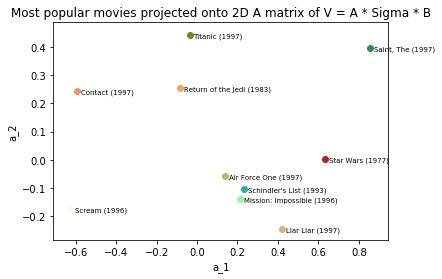

In [57]:
vsx2 = [vsx[index] for index in popularIndices]
vsy2 = [vsy[index] for index in popularIndices]

toUsePop = []
for i in range(20, 101, 8):
    toUsePop.append(sorted_names[i])

plt.clf()
for i in range(len(vsx2)):
    x, y = vsx2[i], vsy2[i]
    plt.scatter(x, y, color=toUsePop[i])
    plt.text(x+.02, y-.01, movieNames[popularIndices[i]], fontsize=7)
plt.title('Most popular movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

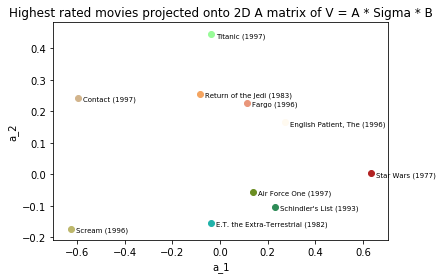

In [82]:
vsx3 = [vsx[index] for index in highestRatedIndices]
vsy3 = [vsy[index] for index in highestRatedIndices]

toUseRat = []
for i in range(20, 101, 8):
    toUseRat.append(sorted_names[i])

plt.clf()
for i in range(len(vsx3)):
    x, y = vsx3[i], vsy3[i]
    plt.scatter(x, y, color=toUseRat[i])
    plt.text(x+.02, y-.01, movieNames[highestRatedIndices[i]], fontsize=7)
plt.title('Highest rated movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

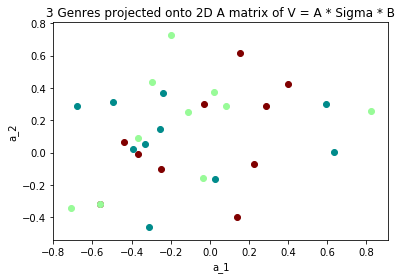

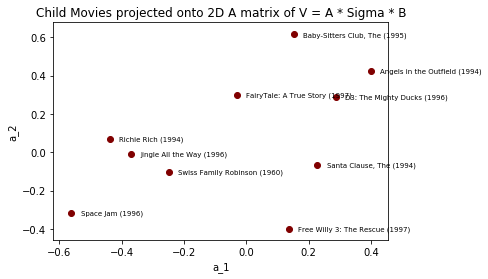

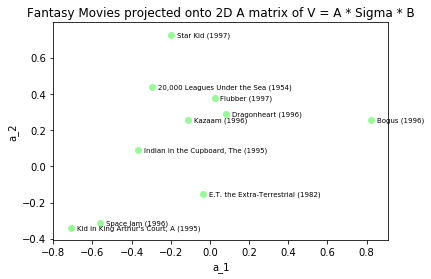

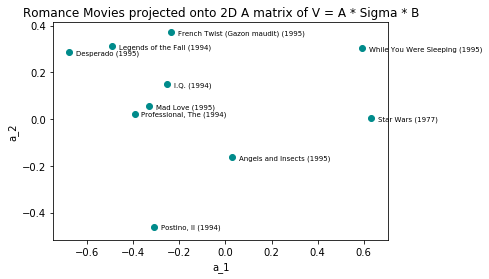

In [59]:
vsx4 = [vsx[index] for index in genreIndices]
vsy4 = [vsy[index] for index in genreIndices]

toUseGen = []
spam = [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 
        76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
for i in spam:
    toUseGen.append(sorted_names[i])

plt.clf()
for i in range(len(vsx4)):
    x, y = vsx4[i], vsy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    # plt.text(x+.02, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('3 Genres projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(0,10):
    x, y = vsx4[i], vsy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Child Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(10,20):
    x, y = vsx4[i], vsy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Fantasy Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

plt.clf()
for i in range(20,30):
    x, y = vsx4[i], vsy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('Romance Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()